# Preprocessing of Calcium Signals

### Methods

Raw fluorescence traces were first corrected for neuropil contamination by subtracting the time-varying neuropil signal of each ROI using a fixed scaling coefficient of 0.7 (Dipoppa et al., 2018). To be able to compare activity across cells and mouse lines, fluorescence signals were then normalized. To do this, we used the ΔF/F0 method, calculated using the following formula: (F-F0)/F0, where F is the fluorescence and F0 is the baseline fluorescence. The baseline fluorescence was calculated by tracking the lower 5th percentile over a sliding window of 2min followed by a Gaussian smoothing with a 2min width. ROIs with baseline fluorescence reaching negative values were discarded from the analysis.

see the function `compute_dFoF` in  [Calcium.py](./Calcium.py)

In [1]:
import numpy as np
import matplotlib.pylab as plt
from Calcium import *

## Computing the $\Delta$F/F

In [2]:
N = 5 # rois
t = np.linspace(0, 1, int(1e3))
x = np.random.randn(N,len(t))+2*(1-t)
sWindow = 30
percentile = 10

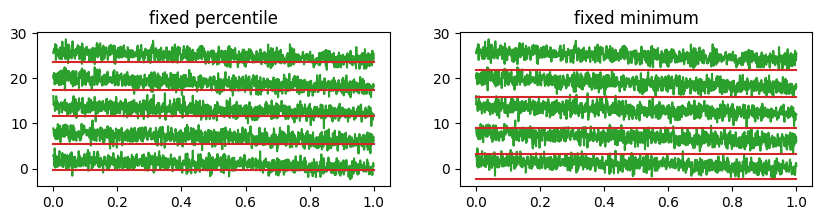

In [8]:
fig, AX = plt.subplots(1, 2, figsize=(10,2))

for ax, title, x0 in zip(AX,
                  ['fixed percentile', 'fixed minimum'],
                  [compute_percentile(x, percentile),
                   compute_minimum(x)]):
    ax.set_title(title)
    for roi in range(N):
        ax.plot(t, 6*roi+x[roi,:], color='tab:green')
        ax.plot(t, 6*roi+x0[roi,:], color='tab:red')

Text(0, 0.5, 'with smoothing')

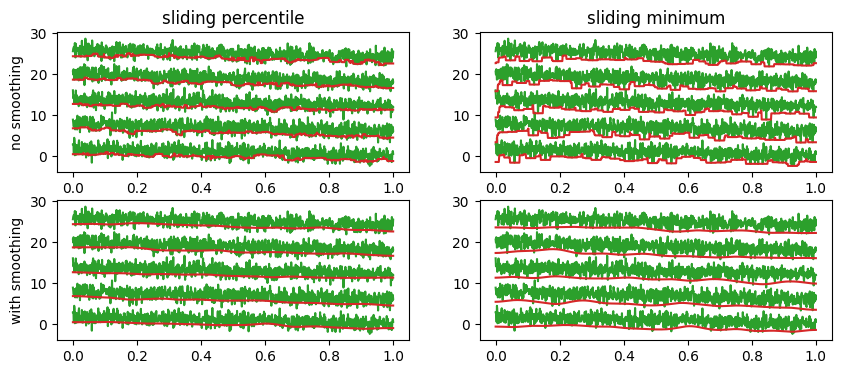

In [3]:
fig, AX = plt.subplots(2, 2, figsize=(10,4))

for ax, title, x0 in zip(AX[0],
                  ['sliding percentile', 'sliding minimum'],
                  [compute_sliding_percentile(x, percentile, sWindow),
                   compute_sliding_minimum(x, sWindow)]):
    ax.set_title(title)
    for roi in range(N):
        ax.plot(t, 6*roi+x[roi,:], color='tab:green')
        ax.plot(t, 6*roi+x0[roi,:], color='tab:red')
for ax, x0 in zip(AX[1],
                  [compute_sliding_percentile(x, percentile, sWindow, with_smoothing=True),
                   compute_sliding_minimum(x, sWindow, with_smoothing=True)]):
    for roi in range(N):
        ax.plot(t, 6*roi+x[roi,:], color='tab:green')
        ax.plot(t, 6*roi+x0[roi,:], color='tab:red')
AX[0][0].set_ylabel('no smoothing')
AX[1][0].set_ylabel('with smoothing')